# Hamilton-Jacobi Reachibility

In the following we will analyse the Hamilton-Jacobi Reachibility for a 1-dimensional coupled space, with state $\vec{x}$ and dynamics $\frac{d}{dt} \vec{x}$: 

\begin{equation}
\vec{x} = \begin{pmatrix}x\\vx\end{pmatrix} = \begin{pmatrix}x_{robot} - x_{pedestrian}\\vx\end{pmatrix}
\end{equation}

\begin{equation}
\frac{d}{dt}\vec{x} = \begin{pmatrix}vx + d\\u\end{pmatrix}
\end{equation}

with $u$ being the control input applied by the robot and $d$ the disturbance, the pedestrian with single integrator dynamics. In order to be provably safe we look for the tube in that the robot's state must be in at every point in time so that no matter what the pedestrian does they both will not collide (collision is modelled here as being less or equal than one meter apart from each other).

The Hamilton-Jacobi Reachibility computes the values of a min-max game, in which the robot chooses its actions in order to avoid some set (here a tube around $\Delta x = 0$) as best as possible while the the disturbance does the oppositie, i.e. the disturbance (aka the pedestrian) tries to push the system in the avoid set. 

In [32]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

In [55]:
import os

import mantrap
import numpy as np
import scipy.io

data_directory = mantrap.utility.io.build_os_path("external/reachibility")
mat = scipy.io.loadmat(os.path.join(data_directory, "1D.mat"), squeeze_me=True)

grid_min = mat["grid_min"].tolist()
grid_max = mat["grid_max"].tolist()
N = mat["N"].tolist()
value_function = mat["value_function_flat"]
gradient = mat["gradient_flat"]
tau = mat["tau"]

In [56]:
# Matlab to pythonic shape conversion.

value_function = np.reshape(value_function, (-1, *N))
value_function = np.fliplr(value_function[-1, :, :])  # -1 = last time-step

gradient = np.reshape(gradient, N)
gradient = np.fliplr(gradient)

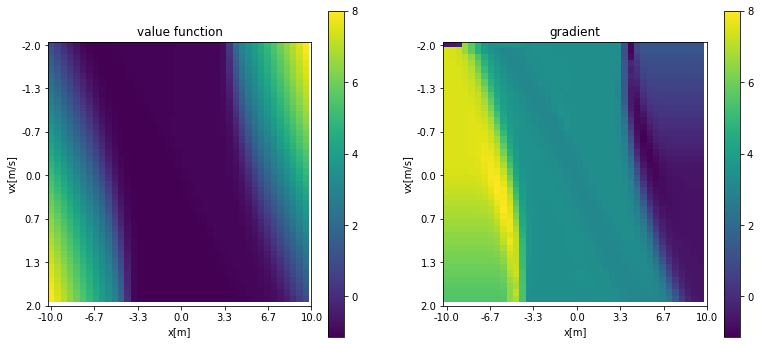

In [57]:
plt.close('all')
fig = plt.figure(figsize=(13, 6))
x_ticks = np.arange(0, N[0] + 1, step=N[0]/6)
y_ticks = np.arange(0, N[1] + 1, step=N[1]/6)

plt.subplot(1, 2, 1)
im = plt.imshow(value_function)
plt.xlabel("x[m]")
plt.ylabel("vx[m/s]")
plt.xticks(x_ticks, np.round(np.linspace(grid_min[0], grid_max[0], num=x_ticks.size), 1))
plt.yticks(y_ticks, np.round(np.linspace(grid_min[1], grid_max[1], num=y_ticks.size), 1))
plt.title("value function")
plt.colorbar(im)

plt.subplot(1, 2, 2)
plt.imshow(gradient)
plt.xlabel("x[m]")
plt.ylabel("vx[m/s]")
plt.xticks(x_ticks, np.round(np.linspace(grid_min[0], grid_max[0], num=x_ticks.size), 1))
plt.yticks(y_ticks, np.round(np.linspace(grid_min[1], grid_max[1], num=y_ticks.size), 1))
plt.title("gradient")
plt.colorbar(im)

plt.show()

The robot is safe over some modelled time horizon (here $\Delta t = 2s$), when the value function at the robot's state is greater zero. Hence, as we can see above, it is only safe at the edge areas of its state space. This is because the disturbance is assumed to be larger in its maximum value than the robot's velocity, and has no inertia being a single integrator system. For example by accelerating in the direction away from the pedestrian in the worst case the robot can only prevent from being less than 1m distant from the pedestrian, if its starts roughly $5 m$ in distance from the pedestrian, with an inital speed of $2 m/s$, ergo ($\vec{x} = (5, 2) \Rightarrow V = 0$).

### Interpolation of Value Tensor

In [128]:
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[grid_min[0]:grid_max[0]:(grid_max[0] - grid_min[0])/N[0],
                          grid_min[1]:grid_max[1]:(grid_max[1] - grid_min[1])/N[1]]
grid_x_new, grid_y_new = np.mgrid[grid_min[0]:grid_max[0]:(grid_max[0] - grid_min[0])/(4 * N[0]),
                                  grid_min[1]:grid_max[1]:(grid_max[1] - grid_min[1])/(4 * N[1])]


points = np.stack((grid_x, grid_y))
points = np.flip(np.rot90(np.transpose(points)), 1).reshape(-1, 2)
values_interpolated = griddata(points, value_function.flatten(), (grid_x_new, grid_y_new), method='cubic')

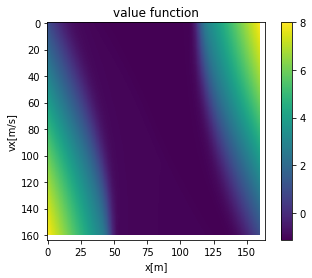

In [129]:
im = plt.imshow(values_interpolated)
plt.xlabel("x[m]")
plt.ylabel("vx[m/s]")
plt.title("value function")
plt.colorbar(im)
plt.show()